At the end of the previous file, we discussed some drawbacks with our initial pipeline implemention. One of the drawbacks was the restriction of only linear running tasks. Using our tasks as an example, we'll show why this is a major drawback that we must address.

In our last file's task pipeline, the final task was to summarize logs that are outputted from a parsed CSV file. The summary is run on the `request_type` column name, but suppose that we wanted to also run a `summarize` on the `status` column. This seems doable – our only requirement should be the parsed CSV – but with our linear pipeline this will **not** work.

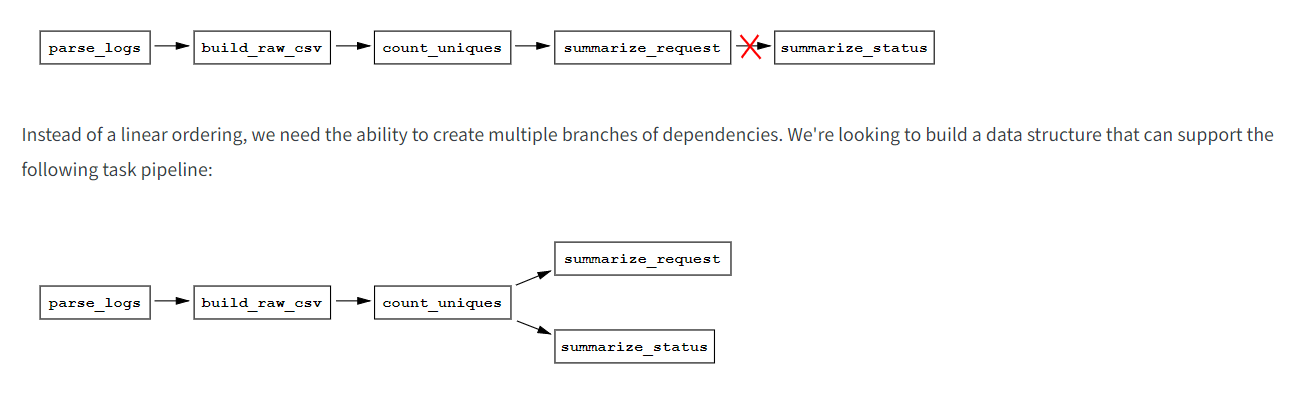

This multiple branching pipeline is called a **directed acyclic graph**, or **DAG** for short. In this file, we will start by building our own DAG in Python, and then use the DAG to enhance our pipeline task scheduling.

In the introduction, we briefly mentioned the concept of a DAG. To describe the DAG, we're going to supplement the language of a graph with identical terms used in the files on trees. Let's break down what each of the terms mean:

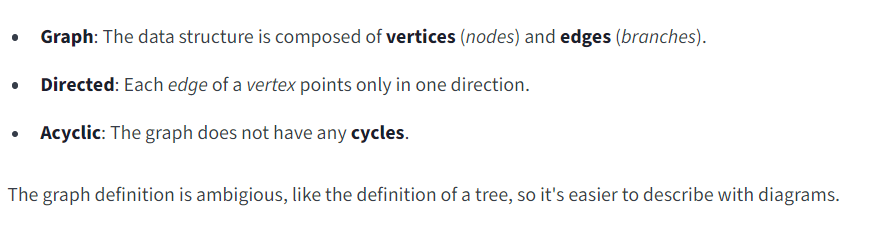

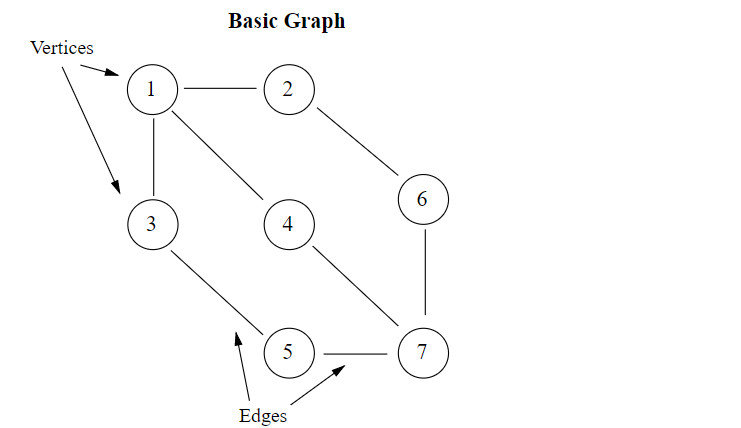

The vertices (or nodes) are each point in the graph, and the edges are the lines that connect them. Note that there is no requirement of the direction of each edge (ie. The edge (2, 1) and (1, 2) are both possible). If we wanted to restrict the direction of an edge to only one possible combination, then it would be called a **directed graph**.

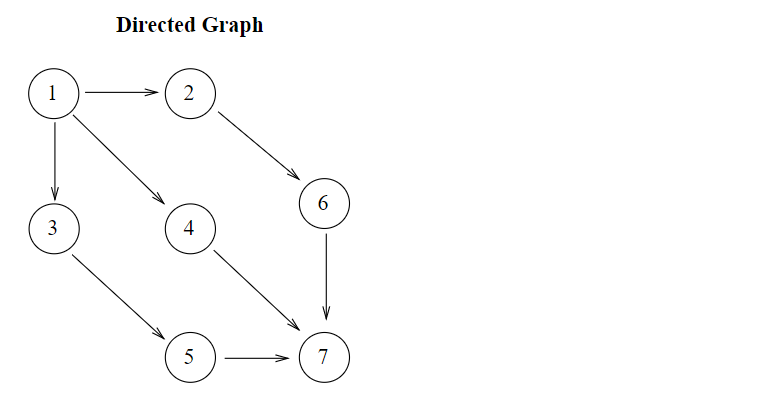

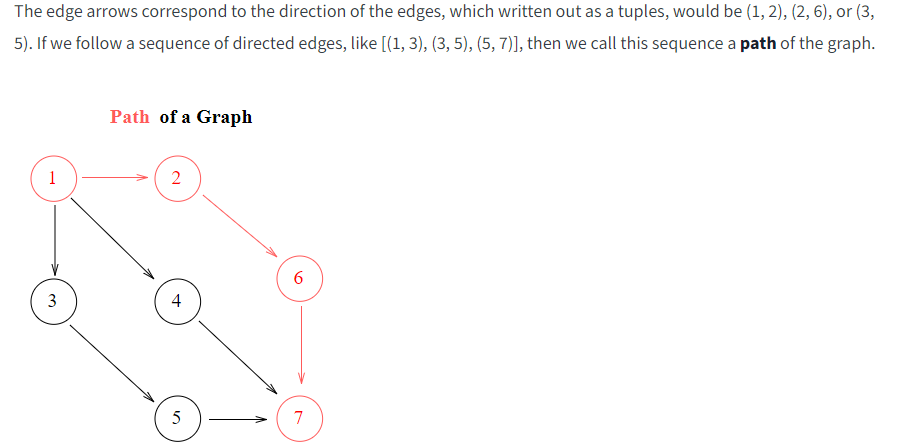

If there are any paths that starts, and ends with one vertex, then the graph contains a *cycle*. For example, if we had a path like [(1, 3), (3, 5), (5, 4), (4, 1)], then it would be a cycle. If a graph does **not** contain any cycles, then it is *acyclic*.

The following graph has a cycle.

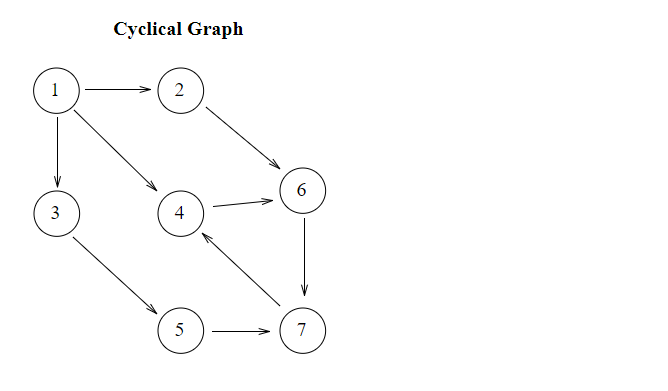

**Task**

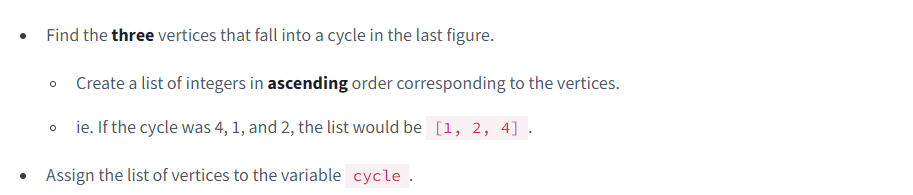

**Answer**

In [1]:
cycle = [4, 6, 7]

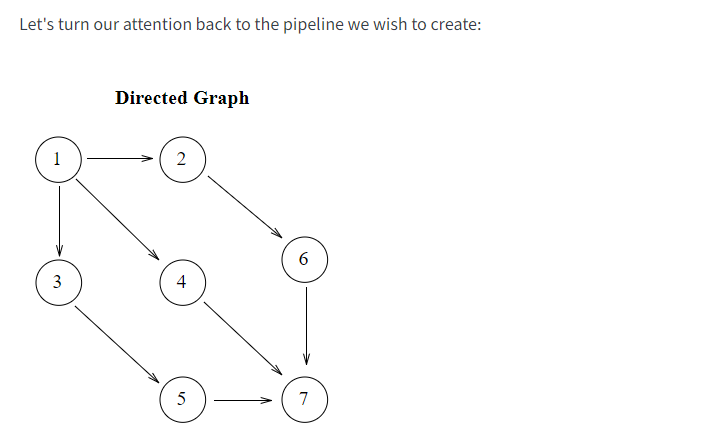

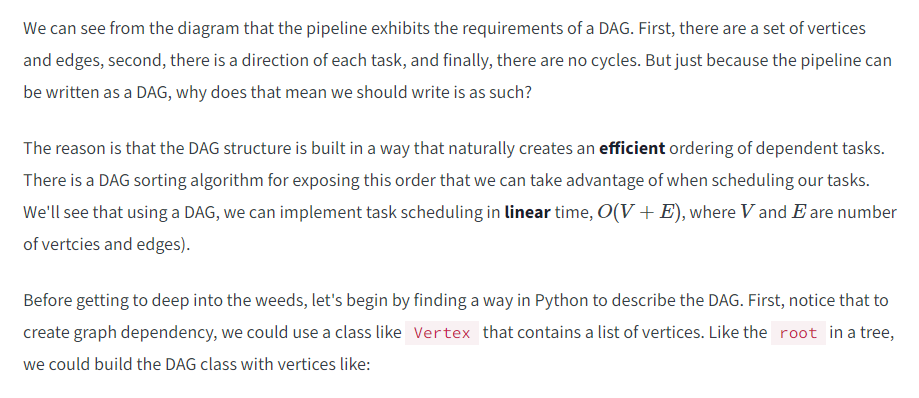

In [2]:
class DAG:
    def __init__(self):
        self.root = Vertex()

class Vertex:
    def __init__(self):
        self.to = []
        self.data = None

dag = DAG()
second = Vertex()
dag.root.to.append(second)

print(dag.root.to)

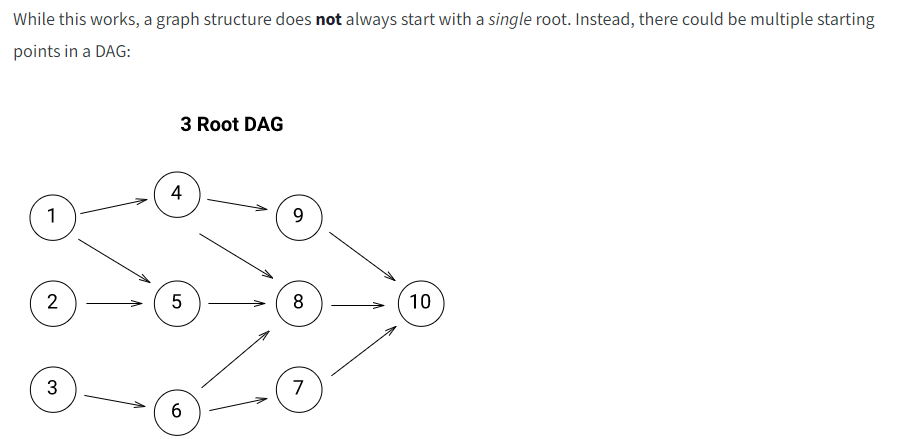

Let's see if there's another data structure we could use. First, we need the ability to link vertices to multiple nodes in the graph. Then, we need to easily loop through these nodes to create our graph.

A simple data structure which provides us with those each of those behaviors is a `dict` with `list` values. Here's how it could represent our example graph:

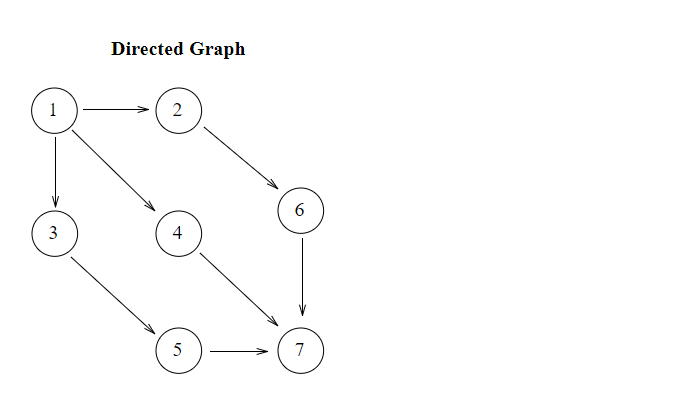

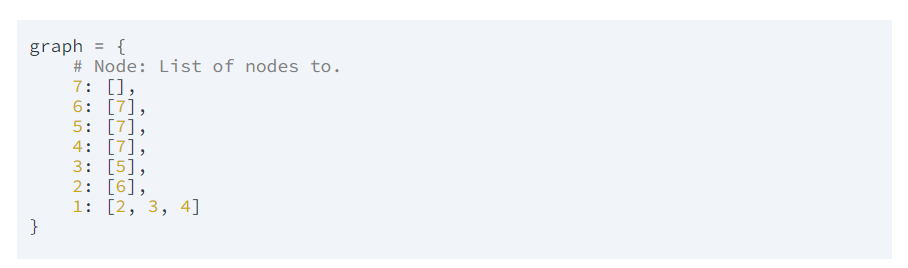

**Task**

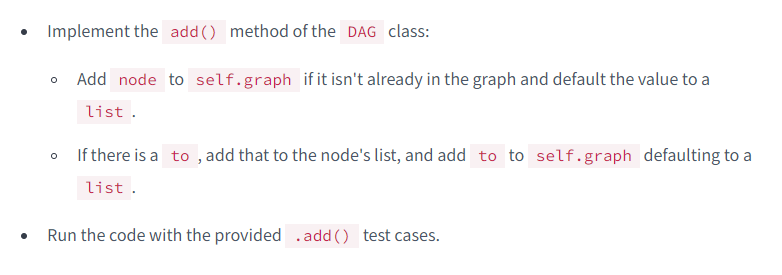

**Answer**

In [4]:
class DAG():
    def __init__(self):
        self.graph = {}
    
    def add(self, node, to=None):
        if not node in self.graph:
            self.graph[node] = []
        if to:
            if not to in self.graph:
                self.graph[to] = []
            self.graph[node].append(to)

dag = DAG()
dag.add(1)
dag.add(1, 2)
dag.add(1, 3)
dag.add(1, 4)
dag.add(3, 5)
dag.add(2, 6)
dag.add(4, 7)
dag.add(5, 7)
dag.add(6, 7)

What does it mean to sort the DAG? In our previous sorting algorithms, we compared object values, and sorted them in ascending or descending order. In a DAG, though, what does it mean to be in ascending or descending order?

Remember, our use case for the DAG was to place tasks in an order of dependencies. What we're looking for is an ordering of tasks that start with the most depended on tasks, and end with the least depended on. In our pipeline example, we're trying to order our tasks to start with parsing a file, and ending with summarizing.

Let's take a look back at our DAG example. At a glance, it's reasonable to assume that the node that is depended on the most is the first node, 1. Then, following the paths, we can see that each node decreases in importance.

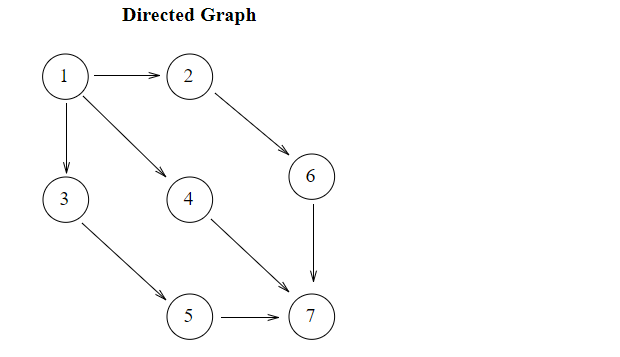

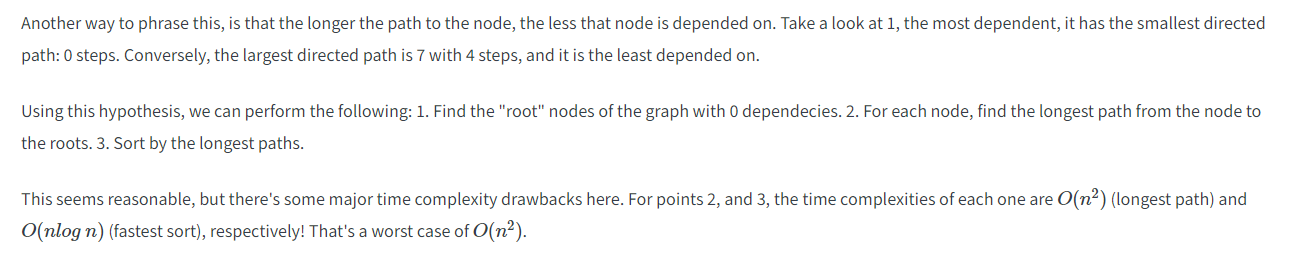

We mentioned that the we can find a sorting algorithm in linear time. Now  we'll use the longer path hypothesis to create a linear time sorting algorithm.

The previous longest path hypothesis wasn't wrong, it was the proposed algorithm that would have taken too long. In the next few screens, we'll develop an efficient algorithm to sort the DAG.

First, to find a longest path, it's necessary to know which nodes "start" the directed graph. By start, we mean the root nodes that the graph expands from. The question is, what determines a root node?

Let's look at the following graph:

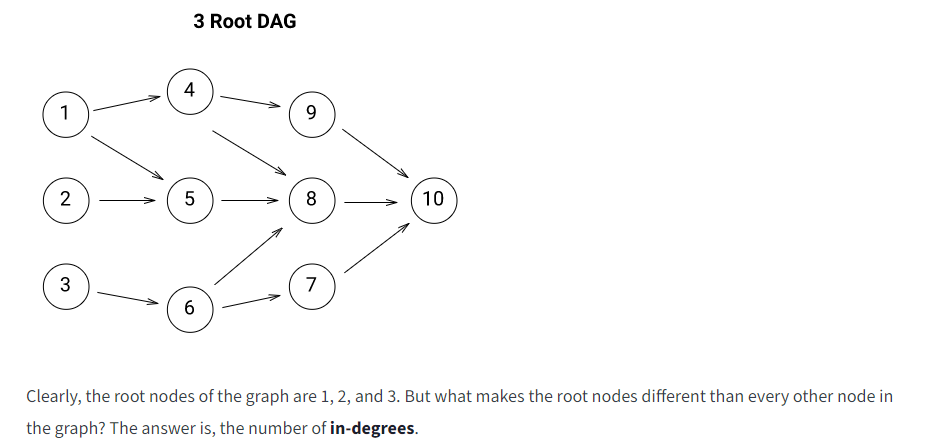

The number of in-degrees is the total count of edges pointing **towards** the node. For example, the node 5 has 2 in-degrees, and the node 8 has 3. For each root node, however, the number of in-degrees will always be 0.

**Task**

Note that we will create a `BaseDAG` class that contains the previous methods. It only contains the single `add()` method we wrote for the last exercise.

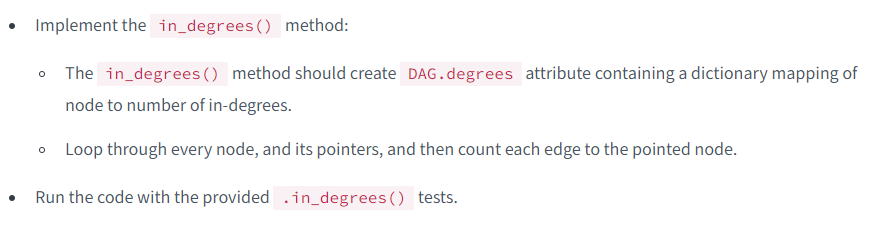

**Answer**

In [8]:
class BaseDAG():
    def __init__(self):
        self.graph = {}
    
    def add(self, node, to=None):
        if not node in self.graph:
            self.graph[node] = []
        if to:
            if not to in self.graph:
                self.graph[to] = []
            self.graph[node].append(to)
            
class DAG(BaseDAG):
    def in_degrees(self):
        self.degrees = {}
        for node in self.graph:
            if node not in self.degrees:
                self.degrees[node] = 0
            for pointed in self.graph[node]:
                if pointed not in self.degrees:
                    self.degrees[pointed] = 0
                self.degrees[pointed] += 1

dag = DAG()
dag.add(1)
dag.add(1, 2)
dag.add(1, 3)
dag.add(1, 4)
dag.add(3, 5)
dag.add(2, 6)
dag.add(4, 7)
dag.add(5, 7)
dag.add(6, 7)
dag.in_degrees()

With the `in_degrees` of each node, we can implement the next part of the algorithm: the walk. First, let's begin by filtering the root nodes. By the definition (discussed above), these are the nodes with `in_degrees` of 0.

`root_nodes = []
for node in in_degrees:
    if in_degrees[node] == 0:
        root_nodes.append(node)`

Now that we have the root nodes, what do we do with them? Well, let's recall what the hypothesis is: the shorter the path, the more the node is depended on. Another way to state the hypothesis is: if there are root nodes, then those nodes are the most important nodes in the tree.

If roots are the most important nodes, then what we should do is the following:

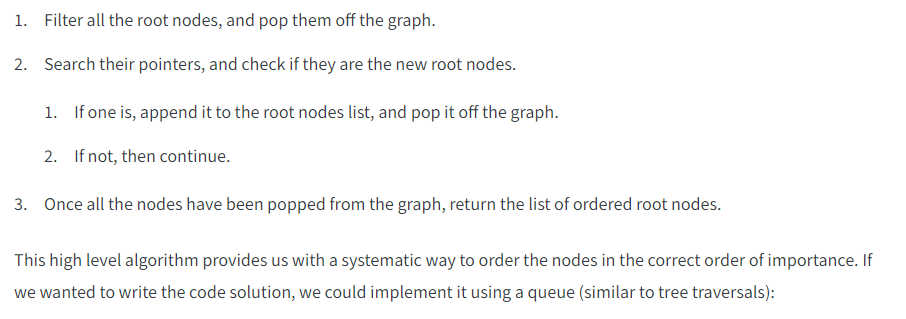

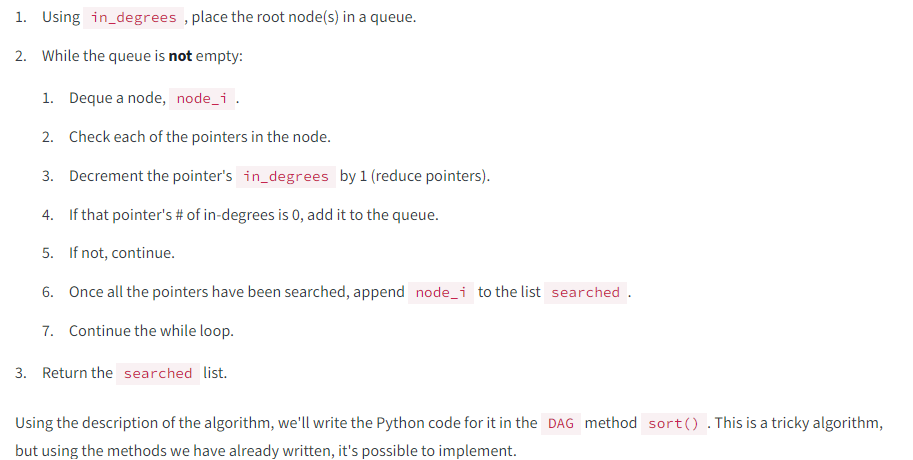

**Task**

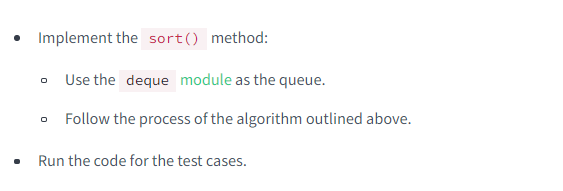

**Answer**

In [11]:
from collections import deque

class DAG(BaseDAG):
    
    def in_degrees(self):
        self.degrees = {}
        for node in self.graph:
            if node not in self.degrees:
                self.degrees[node] = 0
            for pointed in self.graph[node]:
                if pointed not in self.degrees:
                    self.degrees[pointed] = 0
                self.degrees[pointed] += 1
                
    def sort(self):
        self.in_degrees()
        to_visit = deque()
        for node in self.graph:
            if self.degrees[node] == 0:
                to_visit.append(node)
        
        searched = []
        while to_visit:
            node = to_visit.popleft()
            for pointer in self.graph[node]:
                self.degrees[pointer] -= 1
                if self.degrees[pointer] == 0:
                    to_visit.append(pointer)
            searched.append(node)
        return searched

dag = DAG()
dag.add(1)
dag.add(1, 2)
dag.add(1, 3)
dag.add(1, 4)
dag.add(3, 5)
dag.add(2, 6)
dag.add(4, 7)
dag.add(5, 7)
dag.add(6, 7)
dependencies = dag.sort()

The algorithm we wrote above is called a **topological sort**. Specifically, the algorithm we implemented was called [Kahn's Algorithm](https://en.wikipedia.org/wiki/Topological_sorting#Kahn's_algorithm), a famous DAG sorting algorithm. An interesting property about this sorting algorithm is that it can also determine if a graph has a cycle or not.

To test for cyclicity we first sort the DAG, return its toplogically sorted list of visited nodes, and then check the length of sorted nodes. If the length of the sorted nodes is greater than the length of the the nodes in the graph, then there must be a cycle! Because the topological sort visits all pointed nodes, if there is a cycle, we will be visiting a previous node making the visited list greater than the number of vertices in the graph.

For robustness, we should not add a node to the DAG if it makes it cyclical.

**Task**

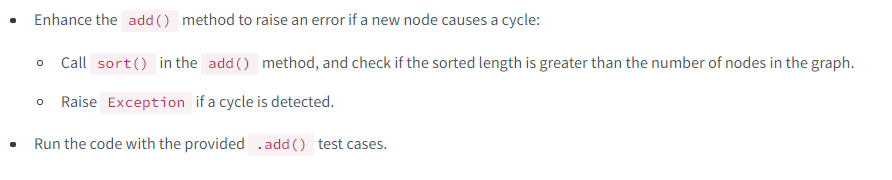

**Answer**

In [13]:
class DAG(BaseDAG):
    
    def in_degrees(self):
        self.degrees = {}
        for node in self.graph:
            if node not in self.degrees:
                self.degrees[node] = 0
            for pointed in self.graph[node]:
                if pointed not in self.degrees:
                    self.degrees[pointed] = 0
                self.degrees[pointed] += 1   
                
    def sort(self):
        self.in_degrees()
        to_visit = deque()
        for node in self.graph:
            if self.degrees[node] == 0:
                to_visit.append(node)
        
        searched = []
        while to_visit:
            node = to_visit.popleft()
            for pointer in self.graph[node]:
                self.degrees[pointer] -= 1
                if self.degrees[pointer] == 0:
                    to_visit.append(pointer)
            searched.append(node)
        return searched
    
    def add(self, node, to=None):
        if not node in self.graph:
            self.graph[node] = []
        if to:
            if not to in self.graph:
                self.graph[to] = []
            self.graph[node].append(to)
            
        if len(self.sort()) != len(self.graph):
            raise Exception
            
dag = DAG()
dag.add(1)
dag.add(1, 2)
dag.add(1, 3)
dag.add(1, 4)
dag.add(3, 5)
dag.add(2, 6)
dag.add(4, 7)
dag.add(5, 7)
dag.add(6, 7)
# Add a pointer from 7 to 4, causing a cycle.
dag.add(7, 4)

Exception: 

Above code is correct and we were expecting an `Exception`

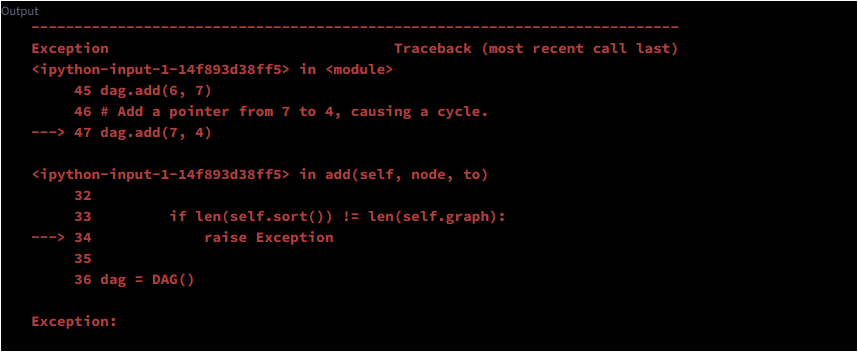

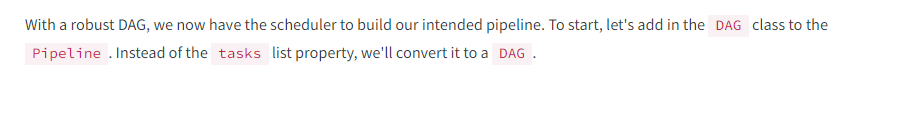

**Task**

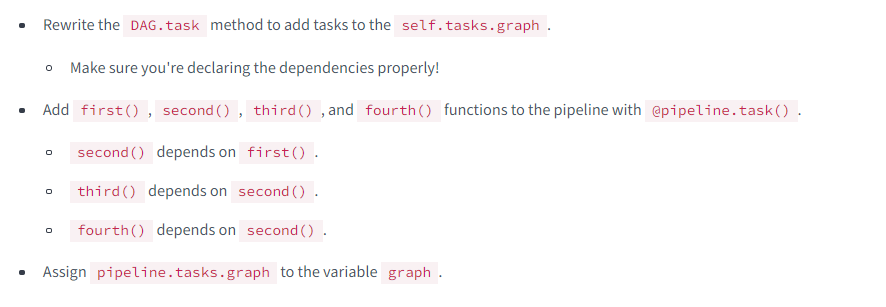

**Answer**

In [14]:
class Pipeline():
    def __init__(self):
        self.tasks = DAG()
        
    def task(self, depends_on=None):
        def inner(f):
            self.tasks.add(f)
            if depends_on:
                self.tasks.add(depends_on, f)
            return f
        return inner

pipeline = Pipeline()
@pipeline.task()
def first():
    return 20

@pipeline.task(depends_on=first)
def second(x):
    return x * 2

@pipeline.task(depends_on=second)
def third(x):
    return x // 3

@pipeline.task(depends_on=second)
def fourth(x):
    return x // 4

graph = pipeline.tasks.graph

In [15]:
graph

{<function __main__.first()>: [<function __main__.second(x)>],
 <function __main__.second(x)>: [<function __main__.third(x)>,
  <function __main__.fourth(x)>],
 <function __main__.third(x)>: [],
 <function __main__.fourth(x)>: []}

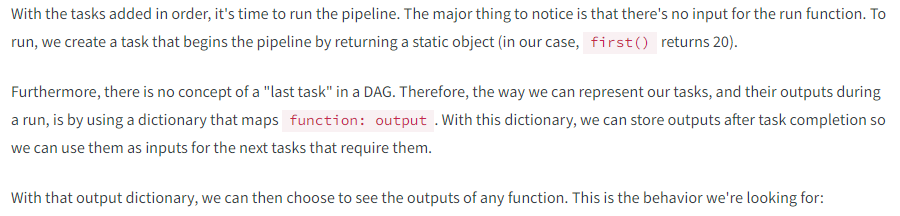

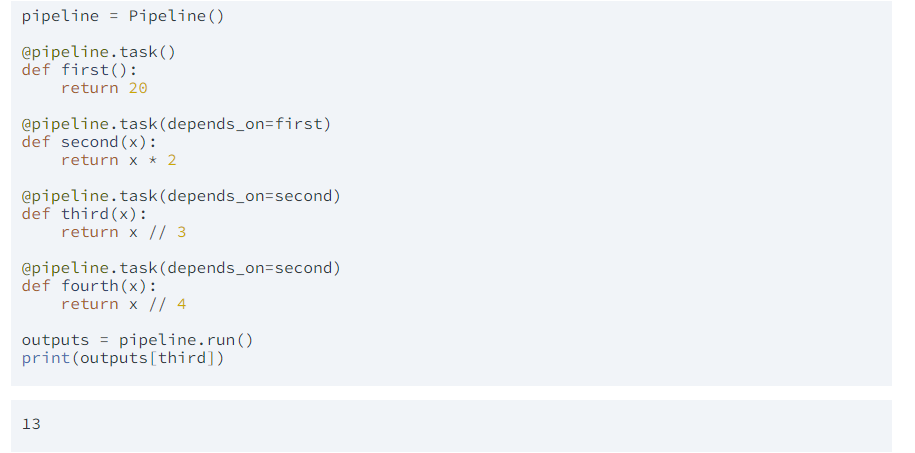

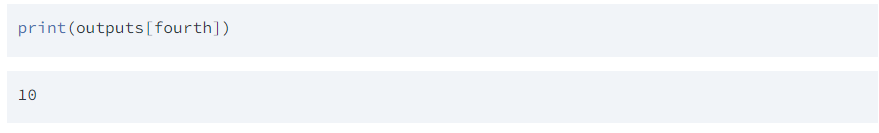

**Task**

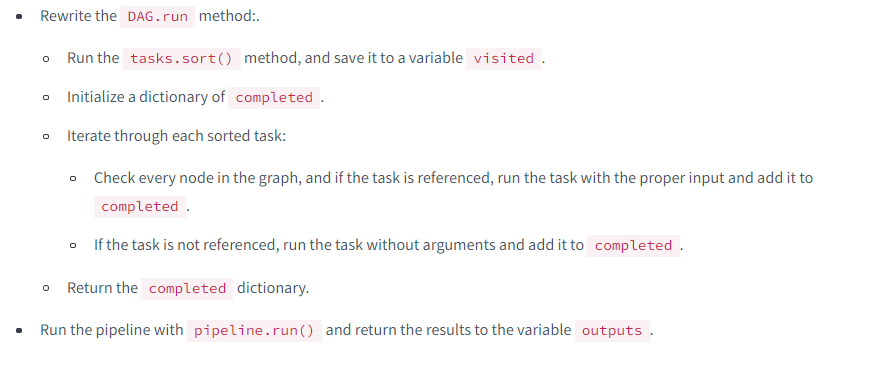

**Answer**

In [17]:
class Pipeline():
    def __init__(self):
        self.tasks = DAG()
        
    def task(self, depends_on=None):
        def inner(f):
            self.tasks.add(f)
            if depends_on:
                self.tasks.add(depends_on, f)
            return f
        return inner
    
    def run(self):
        scheduled = self.tasks.sort()
        completed = {}
        
        for task in scheduled:
            for node, values in self.tasks.graph.items():
                if task in values:
                    completed[task] = task(completed[node])
            if task not in completed:
                completed[task] = task()
        return completed

pipeline = Pipeline()

@pipeline.task()
def first():
    return 20

@pipeline.task(depends_on=first)
def second(x):
    return x * 2

@pipeline.task(depends_on=second)
def third(x):
    return x // 3

@pipeline.task(depends_on=second)
def fourth(x):
    return x // 4

outputs = pipeline.run()

In this file, we solved the linear dependency mapping problem of our pipeline. First, we learned about a DAG, and how we can use it as a task scheduler. Then, we implemented the DAG, and added it to our pipeline.

In the upcoming project, we'll use this new pipeline to built and run it on a real-life case. We'll learn about its drawbacks, and what changes need to be made. Finally, we'll introduce some thirdparty pipelines that we'll discuss in the upcoming files.